# Import Python Libraries

Initial dataset shape: (25870, 21)


[11:05:27] WARNING: not removing hydrogen atom without neighbors
[11:05:27] WARNING: not removing hydrogen atom without neighbors
[11:05:27] WARNING: not removing hydrogen atom without neighbors
[11:05:27] WARNING: not removing hydrogen atom without neighbors
[11:05:27] WARNING: not removing hydrogen atom without neighbors
[11:05:27] WARNING: not removing hydrogen atom without neighbors
[11:05:27] WARNING: not removing hydrogen atom without neighbors
[11:05:27] WARNING: not removing hydrogen atom without neighbors
[11:05:27] WARNING: not removing hydrogen atom without neighbors
[11:05:27] WARNING: not removing hydrogen atom without neighbors
[11:05:27] WARNING: not removing hydrogen atom without neighbors
[11:05:27] WARNING: not removing hydrogen atom without neighbors
[11:05:27] WARNING: not removing hydrogen atom without neighbors
[11:05:27] WARNING: not removing hydrogen atom without neighbors
[11:05:27] WARNING: not removing hydrogen atom without neighbors


Morgan fingerprints dataset shape: (25870, 2048)
Final dataset shape: (25870, 2058)
X_train shape: (20696, 2048)
0:	learn: 1.5873946	total: 6.3ms	remaining: 9.45s
250:	learn: 0.6882893	total: 1.45s	remaining: 7.22s
500:	learn: 0.5919986	total: 2.97s	remaining: 5.92s
750:	learn: 0.5375749	total: 4.85s	remaining: 4.83s
1000:	learn: 0.5009131	total: 6.52s	remaining: 3.25s
1250:	learn: 0.4719423	total: 8.34s	remaining: 1.66s
1499:	learn: 0.4477524	total: 10.2s	remaining: 0us
Test MAE: 0.42502215932905946
Test RMSE: 0.6204042203870681
Test R2: 0.8607412523633681


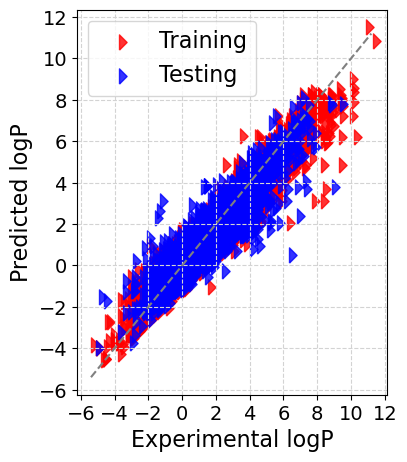

In [3]:
import math
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from gensim.models import word2vec
from sklearn import preprocessing
from catboost import CatBoostRegressor

# Reading organic solvents viscosity data
input_dir = 'D:/Postdoc-Work/Manuacripts/NLP-Organic_Solvents-Properties/Comm Chemistry/Revisions_R1/Data_ML-pred/Morgan-FP/LogP/'
dataset = pd.read_csv(input_dir + 'logP_dataset_Kaggle+NLP_Canonical_SMILES_Uncertain.csv')

# Sorting dataset with unique SMILES
dataset = dataset.drop_duplicates(subset=['SMILES']).sort_values(by='SMILES')
print("Initial dataset shape:", dataset.shape)

mol_smiles = dataset['SMILES']
LogP = dataset['Exp_logp']

# Extracting atom counts
atom_counts = dataset[['C', 'H', 'N', 'O', 'S', 'P', 'F', 'Cl', 'Br', 'I']].values

# Calculate Morgan fingerprints using RDKit
def morgan_fingerprints(smiles, radius=2, n_bits=2048):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits) for mol in mols]
    # Convert the fingerprints to a DataFrame
    fingerprints_array = [list(fp) for fp in fingerprints]
    return pd.DataFrame(fingerprints_array)

# Function call to calculate Morgan fingerprints
fingerprints_df = morgan_fingerprints(dataset['SMILES'])

print("Morgan fingerprints dataset shape:", fingerprints_df.shape)

# Merge fingerprints into the dataset
input_features = pd.concat([fingerprints_df, pd.DataFrame(atom_counts, columns=['C', 'H', 'N', 'O', 'S', 'P', 'F', 'Cl', 'Br', 'I'])], axis=1)

print("Final dataset shape:", input_features.shape)







# Simple train-test split
X_train, X_test, y_train, y_test, smiles_train, smiles_test = train_test_split(
    fingerprints_df, LogP, mol_smiles, test_size=0.2, random_state=536)

print("X_train shape:", X_train.shape)

# Train CatBoost
cat_model = CatBoostRegressor(verbose=250, learning_rate=0.22, n_estimators=1500, l2_leaf_reg=7, rsm=0.6, 
                                   subsample=0.8, random_strength=1, eval_metric='RMSE', min_data_in_leaf=10, 
                                   depth=5, boosting_type='Plain', num_leaves=31)
cat_model.fit(X_train, y_train)

# Predict on train
y_pred_train = cat_model.predict(X_train)
train_df = pd.DataFrame({
    'SMILES': smiles_train.reset_index(drop=True),
    'log_visc_actual': y_train.reset_index(drop=True),
    'log_visc_pred': y_pred_train
})
train_df.to_csv('CATBoost_Morgan-Training_LogP_Comm-Chem-RS536.csv', index=False)

# Predict on test
y_pred_test = cat_model.predict(X_test)
test_df = pd.DataFrame({
    'SMILES': smiles_test.reset_index(drop=True),
    'log_visc_actual': y_test.reset_index(drop=True),
    'log_visc_pred': y_pred_test
})
test_df.to_csv('CATBoost_Morgan-Testing_LogP_Comm-Chem-RS536.csv', index=False)

# Print metrics
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))
print("Test RMSE:", math.sqrt(mean_squared_error(y_test, y_pred_test)))
print("Test R2:", r2_score(y_test, y_pred_test))

# Scatterplot
plt.figure(figsize=(4, 5))
ln = np.arange(min(min(y_train), min(y_test)), max(max(y_train), max(y_test)), 0.2)
plt.plot(ln, ln, 'gray', linestyle='--')

plt.scatter(y_train, y_pred_train, color='red', label='Training', alpha=0.8,
            marker=MarkerStyle("D", fillstyle="right"), s=60)
plt.scatter(y_test, y_pred_test, color='blue', label='Testing', alpha=0.8,
            marker=MarkerStyle("D", fillstyle="right"), s=60)

plt.xlabel('Experimental logP', fontsize=16)
plt.ylabel('Predicted logP', fontsize=16)
plt.xticks(np.arange(12, -8, step=-2), fontsize=14)
plt.yticks(np.arange(12, -8, step=-2), fontsize=14)
plt.grid(color='#D3D3D3', linestyle='--', which='both', axis='both')
plt.legend(loc='upper left', fontsize=16)
# plt.savefig('CATBoost_Morgan-LogP_Comm-Chem-RS536-25000.png', dpi=1200, bbox_inches='tight')
plt.show()
